# Create Training Datasets


In [1]:
%config InlineBackend.figure_format='retina'
import logging
from ekorpkit import eKonf

logging.basicConfig(level=logging.WARNING)
print("version:", eKonf.__version__)
print("is notebook?", eKonf.is_notebook())
print("is colab?", eKonf.is_colab())
print("evironment varialbles:")
eKonf.print(eKonf.env().dict())

version: 0.1.33+20.g8433774.dirty
is notebook? True
is colab? False
evironment varialbles:
{'EKORPKIT_CONFIG_DIR': '/workspace/projects/ekorpkit-book/config',
 'EKORPKIT_DATA_DIR': None,
 'EKORPKIT_PROJECT': 'ekorpkit-book',
 'EKORPKIT_WORKSPACE_ROOT': '/workspace',
 'NUM_WORKERS': 230}


In [2]:
data_dir = "../data/fomc"

## Load preprocessed data


In [3]:
econ_data = eKonf.load_data("econ_data2.parquet", data_dir)
econ_data.tail()


,unscheduled,forecast,confcall,speaker,rate,rate_change,rate_decision,rate_changed,GDP,GDP_diff_prev,...,Rate,Taylor,Balanced,Inertia,Taylor-Rate,Balanced-Rate,Inertia-Rate,Taylor_diff,Balanced_diff,Inertia_diff
date,,,,,,,,,,,,,,,,,,,,,
2021-11-03,False,False,False,Jerome Powell,0.25,0.00,0.0,0,19478.893,0.570948,...,0.25,5.747177,4.940210,-0.528532,5.497177,4.690210,-0.778532,0.0,0.0,0.0
2021-12-15,False,True,False,Jerome Powell,0.25,0.00,0.0,0,19478.893,0.570948,...,0.25,6.472329,5.665362,-0.637304,6.222329,5.415362,-0.887304,0.0,0.0,0.0
2022-01-26,False,False,False,Jerome Powell,0.25,0.00,0.0,0,19478.893,0.570948,...,0.25,7.222928,6.415961,-0.749894,6.972928,6.165961,-0.999894,0.0,0.0,0.0
2022-03-16,False,True,False,Jerome Powell,0.50,0.25,1.0,1,19806.290,1.680778,...,0.25,8.499377,8.267766,-1.027665,8.249377,8.017766,-1.277665,0.0,0.0,0.0
2022-05-04,False,False,False,Jerome Powell,1.00,0.50,1.0,1,19735.895,-0.355417,...,0.50,8.094924,7.420939,-0.688141,7.594924,6.920939,-1.188141,0.0,0.0,0.0


## EDA on numerical data


In [4]:
# Add previous rate decision to see inertia effect
econ_data["Rate Decision"] = econ_data["rate_decision"].map(
    lambda x: "Cut" if x <= -1 else "Hike" if x >= 1 else "Hold"
)
econ_data["rate_decision"] = econ_data["rate_decision"].map(
    lambda x: -1 if x <= -1 else 1 if x >= 1 else 0
)
econ_data["prev_decision"] = econ_data["rate_decision"].shift(1)
econ_data["next_decision"] = econ_data["rate_decision"].shift(-1)
econ_data[["Rate Decision", "rate_decision", "prev_decision", "next_decision"]].head()


,Rate Decision,rate_decision,prev_decision,next_decision
date,,,,
1982-10-05,Cut,-1,NaN,-1.0
1982-11-16,Cut,-1,-1.0,0.0
1982-12-21,Hold,0,-1.0,0.0
1983-01-14,Hold,0,0.0,0.0
1983-01-21,Hold,0,0.0,0.0


In [20]:
columns = [
    "Rate Decision",
    "prev_decision",
    "GDP_diff_prev",
    "PMI",
    "EMP_diff_prev",
    "RSALES_diff_year",
    "UNEMP_diff_prev",
    "HSALES_diff_year",
    "Inertia_diff",
    "Balanced_diff",
]

econ_train_small = econ_data.copy()[columns]
econ_train_small.rename(columns={"Rate Decision": "target"}, inplace=True)
print(econ_train_small.shape)
econ_train_small.tail()

(415, 10)


,target,prev_decision,GDP_diff_prev,PMI,EMP_diff_prev,RSALES_diff_year,UNEMP_diff_prev,HSALES_diff_year,Inertia_diff,Balanced_diff
date,,,,,,,,,,
2021-11-03,Hold,0.0,0.570948,60.5,0.288624,8.474656,-9.615385,-26.135217,0.0,0.0
2021-12-15,Hold,0.0,0.570948,60.6,0.437147,10.977142,-8.695652,-11.163337,0.0,0.0
2022-01-26,Hold,0.0,0.570948,58.8,0.395555,9.101289,-7.142857,-3.673938,0.0,0.0
2022-03-16,Hike,0.0,1.680778,58.6,0.476814,9.076698,-5.000000,3.125000,0.0,0.0
2022-05-04,Hike,1.0,-0.355417,57.1,0.283658,-0.034915,0.000000,-26.946848,0.0,0.0


In [21]:
# Large dataset
columns = [
    "Rate Decision",
    "prev_decision",
    "GDP_diff_prev",
    "GDP_diff_year",
    "GDPPOT_diff_prev",
    "GDPPOT_diff_year",
    "PCE_diff_prev",
    "PCE_diff_year",
    "CPI_diff_prev",
    "CPI_diff_year",
    "UNEMP",
    "UNEMP_diff_prev",
    "UNEMP_diff_year",
    "EMP",
    "EMP_diff_prev",
    "EMP_diff_year",
    "PMI",
    "PMI_diff_prev",
    "PMI_diff_year",
    "RSALES_diff_prev",
    "RSALES_diff_year",
    "HSALES_diff_prev",
    "HSALES_diff_year",
    "Taylor-Rate",
    "Balanced-Rate",
    "Inertia-Rate",
    "Taylor_diff",
    "Balanced_diff",
    "Inertia_diff",
]


econ_train_large = econ_data.copy()[columns]
econ_train_large.rename(columns={"Rate Decision": "target"}, inplace=True)
print(econ_train_large.shape)

(415, 29)


### Missing Values


In [22]:
# As most likely the decision is 0 (hold), fill prev_decision of the first row
econ_train_small["prev_decision"].fillna(0, inplace=True)
econ_train_large["prev_decision"].fillna(0, inplace=True)


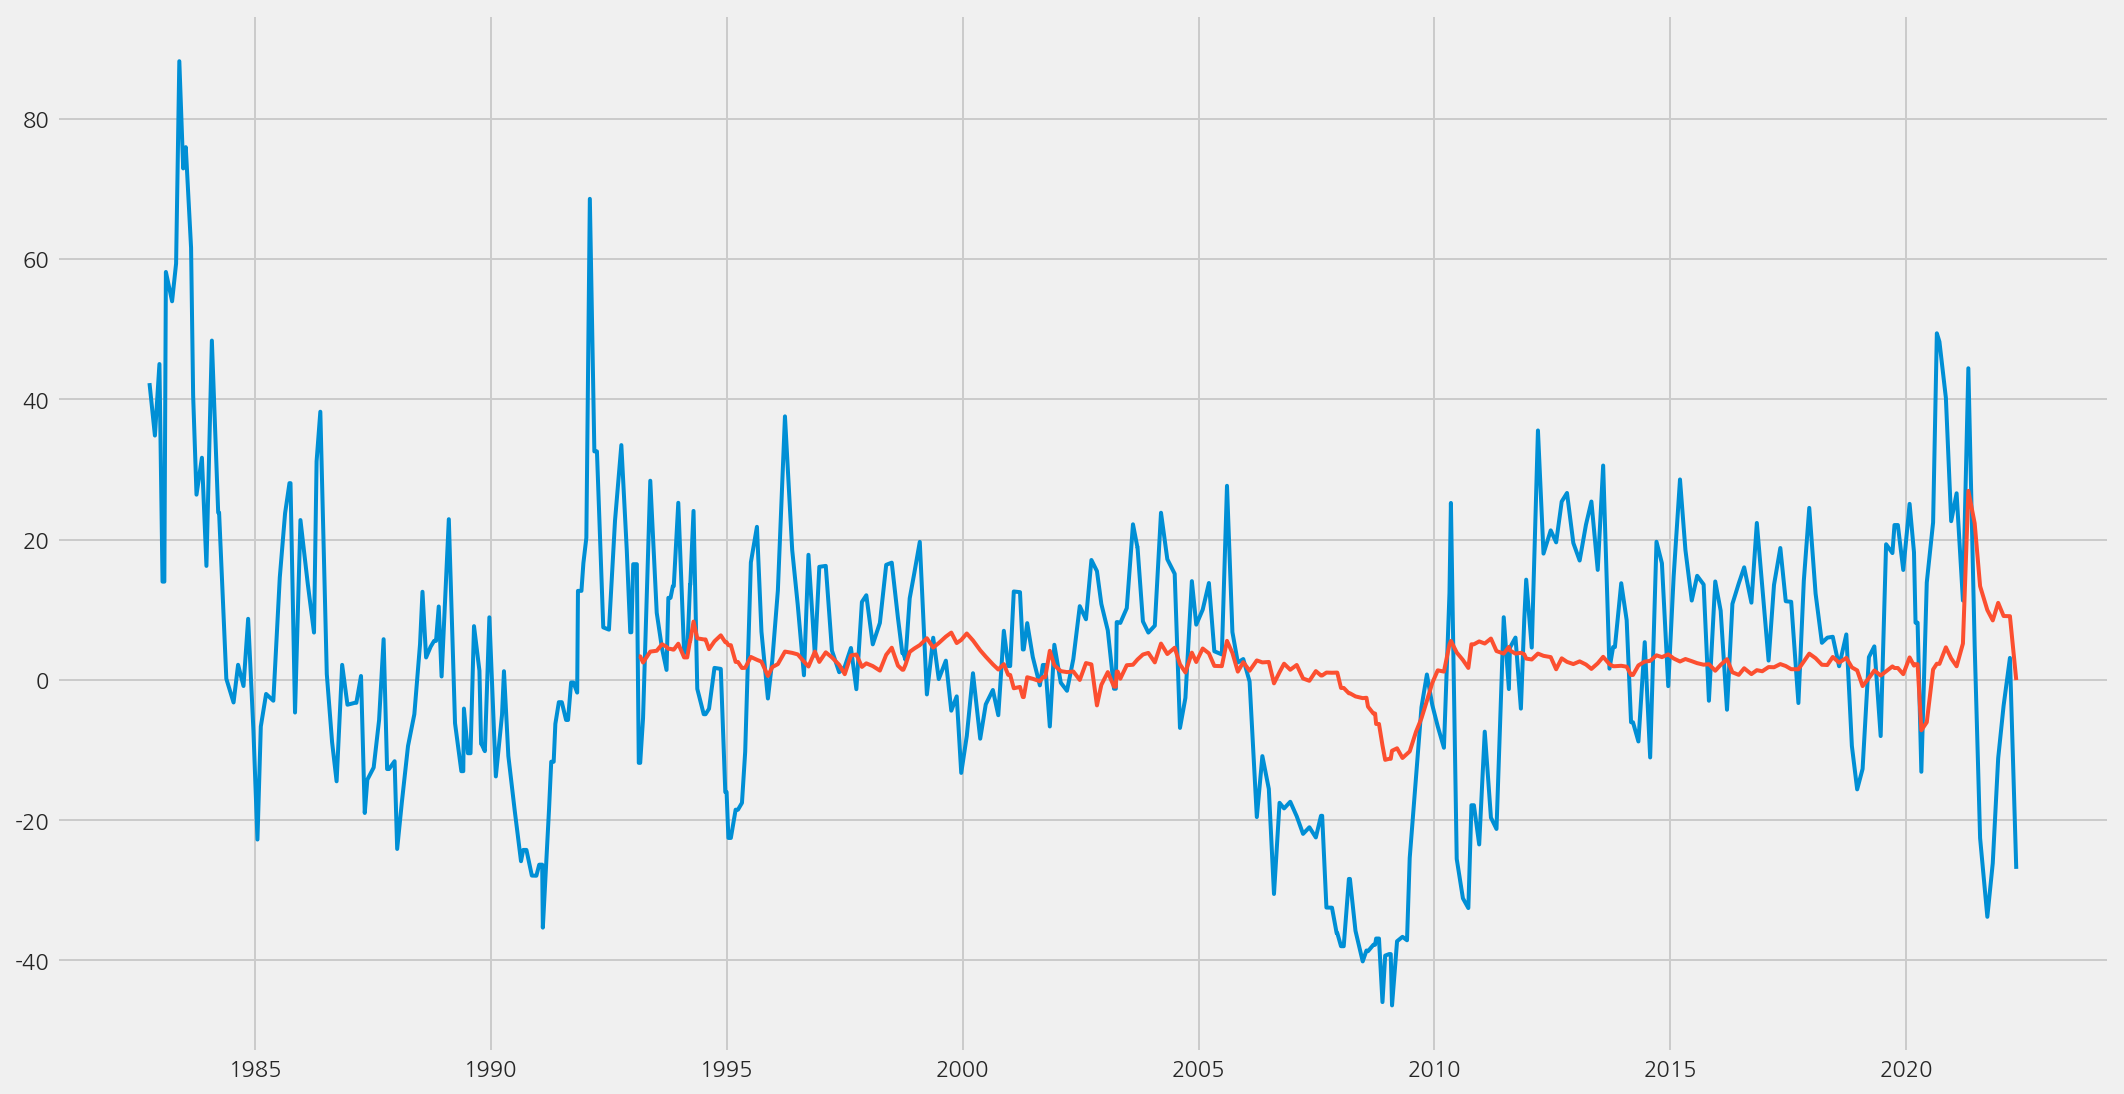

In [23]:
# ax.set_xlim(0, 400)
cfg = eKonf.compose("visualize/plot=lineplot")
cfg.figure.figsize = (15, 8)
cfg.lineplot.x = "date"
cfg.lineplot.y = "HSALES_diff_year"

lineplot = cfg.lineplot.copy()
lineplot.x = "date"
lineplot.y = "RSALES_diff_year"
cfg.plots.append(lineplot)

eKonf.instantiate(cfg, data=econ_train_small)


In [24]:
# Retail sales growth ratio is difficult to estimate. Though it is not ideal, simply use the average
econ_train_small["RSALES_diff_year"].fillna(
    econ_train_small["RSALES_diff_year"].mean(), inplace=True
)
econ_train_large["RSALES_diff_prev"].fillna(
    econ_train_large["RSALES_diff_prev"].mean(), inplace=True
)
econ_train_large["RSALES_diff_year"].fillna(
    econ_train_large["RSALES_diff_year"].mean(), inplace=True
)
econ_train_small["Inertia_diff"].fillna(
    econ_train_small["Inertia_diff"].mean(), inplace=True
)
econ_train_small["Balanced_diff"].fillna(
    econ_train_small["Balanced_diff"].mean(), inplace=True
)
econ_train_large["Inertia_diff"].fillna(
    econ_train_large["Inertia_diff"].mean(), inplace=True
)
econ_train_large["Balanced_diff"].fillna(
    econ_train_large["Balanced_diff"].mean(), inplace=True
)
econ_train_large["Taylor_diff"].fillna(
    econ_train_large["Taylor_diff"].mean(), inplace=True
)

### Save Data


In [25]:
eKonf.save_data(econ_train_small, "econ_train_small.parquet", data_dir)
eKonf.save_data(econ_train_large, "econ_train_large.parquet", data_dir)
